In [8]:
%load_ext autoreload
%autoreload 2
%run ./initializer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Path (/Users/rik/Documents/VU/DMT/DataMiningTechniquesA1) already exists in sys.path


In [9]:
import torch
import torch.nn as nn
import optuna
from sklearn.model_selection import train_test_split
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt

from data_loading import DataPreprocessor
from mood_RNN_regression import RNNRegressor, MoodDataset, objective, train_epoch, train_final_model, evaluate, predict, plot_mood_predictions
from torch.utils.data import DataLoader

In [10]:
data_loader = DataPreprocessor()
train_df_split, val_df_split, pred_df = data_loader.load_and_preprocess_data("1d", 0.5, 1, do_bucketing=False)

Removed 24 outliers from 1002 observations. Percentage: 2.40%


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume train_df and test_df are loaded and preprocessed
id_map = {id_: idx for idx, id_ in enumerate(train_df_split['id'].unique())}
input_dim = train_df_split.drop(columns=['id', 'mood', 'date']).shape[1]
id_count = len(id_map)

In [12]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, train_df_split, val_df_split, id_map, input_dim, id_count, device), n_trials=100)

best_params = study.best_params
print("Best hyperparams:", best_params)

[I 2025-04-20 13:33:27,083] A new study created in memory with name: no-name-76cb66a2-b9b7-4c6e-a274-9da4f062a379
[I 2025-04-20 13:33:33,599] Trial 0 finished with value: 0.930216161828292 and parameters: {'hidden_dim': 110, 'id_embed_dim': 15, 'lr': 0.001792021817593459, 'batch_size': 128}. Best is trial 0 with value: 0.930216161828292.
[I 2025-04-20 13:33:33,971] Trial 1 finished with value: 20.53767957185444 and parameters: {'hidden_dim': 97, 'id_embed_dim': 14, 'lr': 0.00022370145834871695, 'batch_size': 64}. Best is trial 0 with value: 0.930216161828292.
[I 2025-04-20 13:33:34,516] Trial 2 finished with value: 2.5788660838191673 and parameters: {'hidden_dim': 109, 'id_embed_dim': 6, 'lr': 0.0003627494880015274, 'batch_size': 32}. Best is trial 0 with value: 0.930216161828292.
[I 2025-04-20 13:33:35,058] Trial 3 finished with value: 0.7614987237112862 and parameters: {'hidden_dim': 110, 'id_embed_dim': 6, 'lr': 0.0018734002142755102, 'batch_size': 32}. Best is trial 3 with value: 0

Best hyperparams: {'hidden_dim': 48, 'id_embed_dim': 12, 'lr': 0.002030766643847226, 'batch_size': 64}


In [13]:
# Final model
model = RNNRegressor(
    input_dim=input_dim,
    hidden_dim=best_params['hidden_dim'],
    id_count=id_count,
    id_embed_dim=best_params['id_embed_dim'],
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = nn.MSELoss()

train_loader = DataLoader(MoodDataset(train_df_split, id_map), batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(MoodDataset(val_df_split, id_map), batch_size=best_params['batch_size'])

In [14]:
model = train_final_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=25)

Epoch 1: train loss = 47.2868, val loss = 44.2347
Epoch 2: train loss = 41.7545, val loss = 37.5946
Epoch 3: train loss = 33.5860, val loss = 27.9525
Epoch 4: train loss = 22.8214, val loss = 16.9166
Epoch 5: train loss = 12.4244, val loss = 8.4034
Epoch 6: train loss = 5.9583, val loss = 4.6177
Epoch 7: train loss = 3.4700, val loss = 3.1278
Epoch 8: train loss = 2.4671, val loss = 2.4095
Epoch 9: train loss = 1.8132, val loss = 1.9116
Epoch 10: train loss = 1.4026, val loss = 1.5305
Epoch 11: train loss = 1.1017, val loss = 1.3183
Epoch 12: train loss = 0.9012, val loss = 1.1240
Epoch 13: train loss = 0.7569, val loss = 0.9862
Epoch 14: train loss = 0.6544, val loss = 0.8847
Epoch 15: train loss = 0.5793, val loss = 0.8095
Epoch 16: train loss = 0.5207, val loss = 0.7512
Epoch 17: train loss = 0.4821, val loss = 0.7088
Epoch 18: train loss = 0.4448, val loss = 0.6862
Epoch 19: train loss = 0.4221, val loss = 0.6706
Epoch 20: train loss = 0.3993, val loss = 0.6155
Epoch 21: train loss

MAE: 0.5808, MSE: 0.5649, MAPE: 8.2412%, MSPE: 7.8058%, R_squared: -0.0129


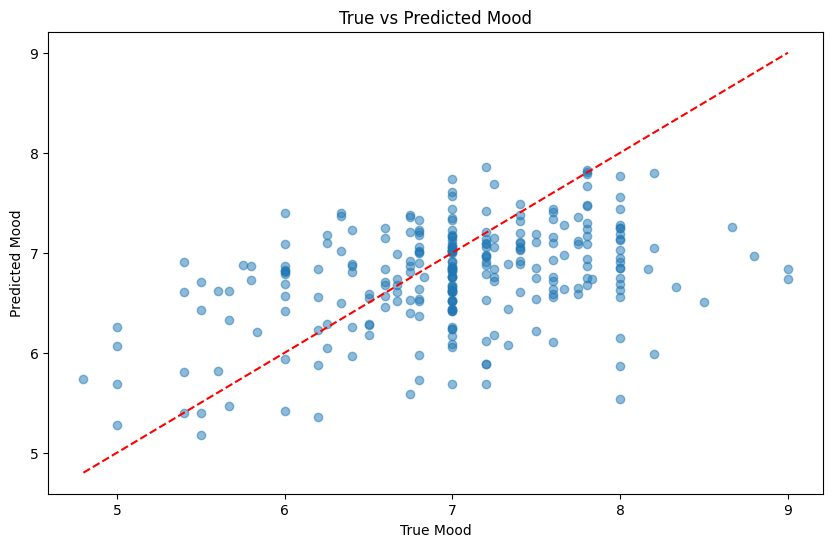

In [15]:
plot_mood_predictions(model, val_loader, device)

In [16]:
# Run predictions on test_df
test_predictions = predict(model, pred_df, id_map, device)

# Attach predictions to test_df
test_df_with_preds = pred_df.copy()
test_df_with_preds['predicted_mood'] = test_predictions

# Optional: save to CSV or examine
print(test_df_with_preds[['id', 'predicted_mood']])

         id  predicted_mood
0   AS14.01             NaN
1   AS14.02        6.657411
2   AS14.03             NaN
3   AS14.05        6.162037
4   AS14.06             NaN
5   AS14.07        5.522363
6   AS14.08        6.572834
7   AS14.09        6.393067
8   AS14.12        6.167318
9   AS14.13        6.694211
10  AS14.14        7.027475
11  AS14.15             NaN
12  AS14.16             NaN
13  AS14.17             NaN
14  AS14.19        6.991030
15  AS14.20        6.886185
16  AS14.23             NaN
17  AS14.24             NaN
18  AS14.25             NaN
19  AS14.26        6.822988
20  AS14.27        7.273236
21  AS14.28             NaN
22  AS14.29        7.352727
23  AS14.30        6.842359
24  AS14.31             NaN
25  AS14.32             NaN
26  AS14.33        5.682037
